# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(f'data{os.sep}heart.csv')
data = df.copy()

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Preprocessing
qua ho fatto un po' di roba a cazzo di cane giusto per avere dei labels


In [5]:
df["Age"] = pd.qcut(x=data["Age"], q=4, labels=["Young adults", "middleage", "almost old", "old"])
df["RestingBP"] = pd.qcut(x=data["RestingBP"], q=3, labels=["low", "medium", "high"])
df["Cholesterol"] = pd.qcut(x=data["Cholesterol"], q=3, labels=["low", "medium", "high"])
df["MaxHR"] = pd.qcut(x=data["MaxHR"], q=3, labels=["low", "medium", "high"])
df["Oldpeak"] = pd.qcut(x=data["Oldpeak"], q=3, labels=["low", "medium", "high"])

In [6]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,Young adults,M,ATA,medium,high,0,Normal,high,N,low,Up,0
1,middleage,F,NAP,high,low,0,Normal,high,N,medium,Flat,1
2,Young adults,M,ATA,medium,high,0,ST,low,N,low,Up,0
3,middleage,F,ASY,medium,medium,0,Normal,low,Y,high,Flat,1
4,middleage,M,NAP,high,low,0,Normal,low,N,low,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,Young adults,M,TA,low,high,0,Normal,medium,N,medium,Flat,1
914,old,M,ASY,high,low,1,Normal,medium,N,high,Flat,1
915,almost old,M,ASY,medium,low,0,Normal,low,Y,medium,Flat,1
916,almost old,F,ATA,medium,medium,0,LVH,high,N,low,Flat,1


<Axes: >

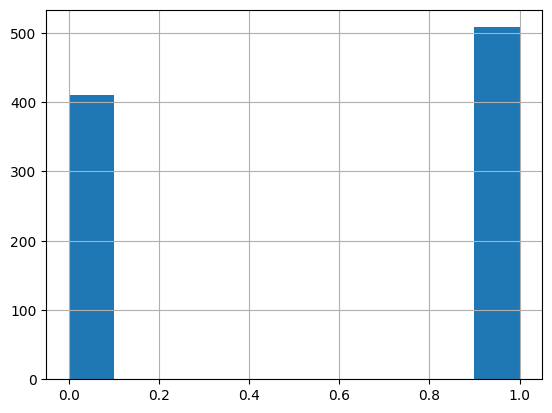

In [32]:
df["HeartDisease"].hist()

# Maximum Likelihood Estimator

In [7]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Creating train e test

In [8]:
Y = df["HeartDisease"]
X = df.drop("HeartDisease", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

## Creating a naive bayes network

In [9]:
columns = list(df.columns)
network = [("HeartDisease", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

## Creating the estimator on the train set and applying its result to our network

In [10]:
estimator = MaximumLikelihoodEstimator(nb_model, xtrain.join(ytrain))

In [11]:
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

## Make a prediction based on the CPDS given

In [12]:
ypred = nb_model.predict(xtest)

  0%|          | 0/222 [00:00<?, ?it/s]

100%|██████████| 222/222 [00:00<00:00, 4605.91it/s]


In [13]:
accuracy_score(ypred, ytest)

0.9

In [14]:
roc_auc_score(ytest, ypred, average="weighted")

0.8976923076923077

# Bayesian estimator

In [15]:
from pgmpy.estimators import BayesianEstimator

In [16]:
nb_model = BayesianNetwork(network)

In [17]:
estimator = BayesianEstimator(nb_model, xtrain.join(ytrain))

In [18]:
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

In [19]:
ypred = nb_model.predict(xtest)

100%|██████████| 222/222 [00:00<00:00, 4606.91it/s]


In [20]:
accuracy_score(ypred, ytest)

0.9

In [21]:
roc_auc_score(ytest, ypred, average="weighted")

0.8976923076923077

 # Learning from data

In [22]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch

# PC

usando PC non funziona perchè crea due grafi separati, c'è da studiare perché

In [33]:
network = [("HeartDisease", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

Y = df["HeartDisease"]
X = df.drop("HeartDisease", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

In [ ]:
est = PC(data=df)
estimated_model = est.estimate(variant="parallel", max_cond_vars=2)

In [40]:

import networkx as nx

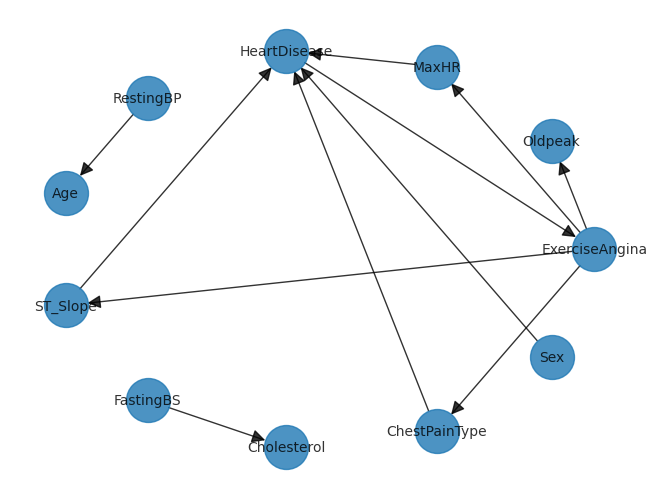

In [41]:
nx.draw_circular(estimated_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [42]:
nb_model = BayesianNetwork(estimated_model)

NetworkXError: Input is not a correct NetworkX graph.

In [38]:
estimator = MaximumLikelihoodEstimator(nb_model, xtrain.join(ytrain))

for _ in estimator.get_parameters():
    nb_model.add_cpds(_)


ypred = nb_model.predict(xtest)

/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

ValueError: Data has variables which are not in the model

# Hill Climbing

  0%|          | 22/1000000 [00:00<5:55:32, 46.88it/s]


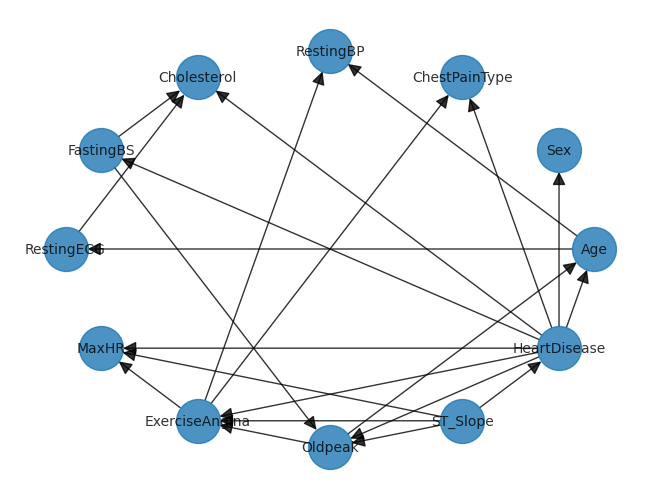

In [46]:
network = [("HeartDisease", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

Y = df["HeartDisease"]
X = df.drop("HeartDisease", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

est = HillClimbSearch(data=df)
estimated_model = est.estimate()

nx.draw_circular(estimated_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [47]:
nb_model = BayesianNetwork(estimated_model)

In [ ]:
estimator = MaximumLikelihoodEstimator(nb_model, xtrain.join(ytrain))

for _ in estimator.get_parameters():
    nb_model.add_cpds(_)


ypred = nb_model.predict(xtest)

In [49]:
roc_auc_score(ytest, ypred)

0.8510863804981452